## Initializing the code

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, Embedding, Dropout, add
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from PIL import Image as PILImage
from tqdm.notebook import tqdm
import random
import pandas as pd
import numpy as np
import pickle
import os
import re

In [2]:
images_path = 'flickr 8k/Images'
captions_df = pd.read_csv('flickr 8k/captions.txt')

In [3]:
# getting list of image files

images_name_list = os.listdir(images_path)
len(images_name_list)

8091

In [4]:
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
captions_df.isna().sum()

image      0
caption    0
dtype: int64

1000268201_693b08cb0e.jpg , size: (375, 500)
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


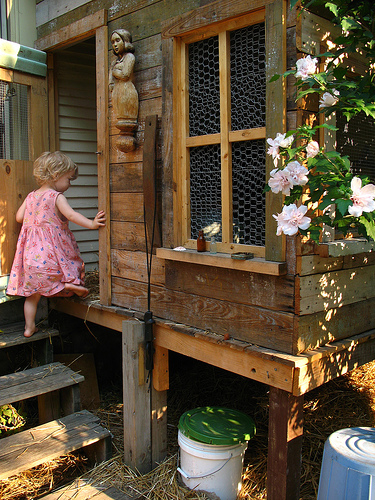


1001773457_577c3a7d70.jpg , size: (500, 375)
A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .
A black dog and a white dog with brown spots are staring at each other in the street .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .


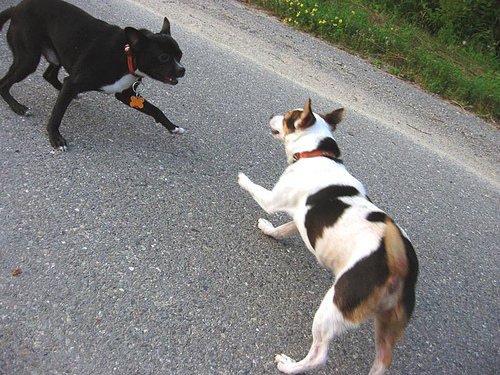


1002674143_1b742ab4b8.jpg , size: (500, 400)
A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


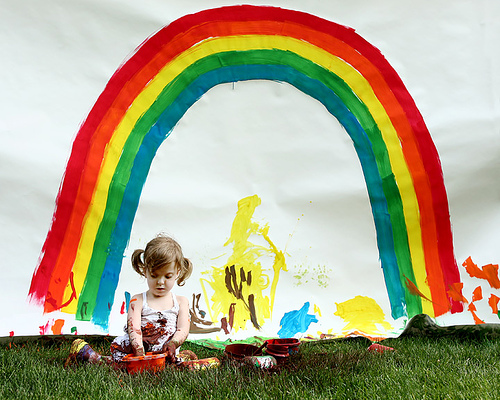


1003163366_44323f5815.jpg , size: (500, 410)
A man lays on a bench while his dog sits by him .
A man lays on the bench to which a white dog is also tied .
a man sleeping on a bench outside with a white and black dog sitting next to him .
A shirtless man lies on a park bench with his dog .
man laying on bench holding leash of dog sitting on ground


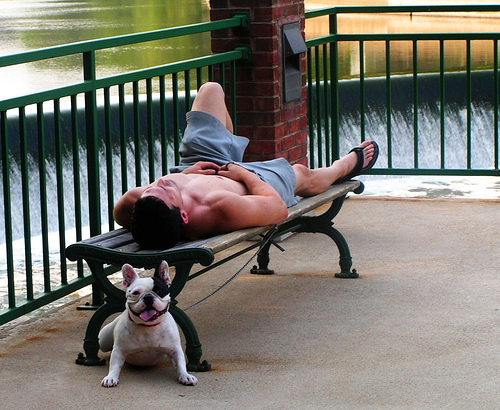


1007129816_e794419615.jpg , size: (500, 461)
A man in an orange hat starring at something .
A man wears an orange hat and glasses .
A man with gauges and glasses is wearing a Blitz hat .
A man with glasses is wearing a beer can crocheted hat .
The man with pierced ears is wearing glasses and an orange hat .


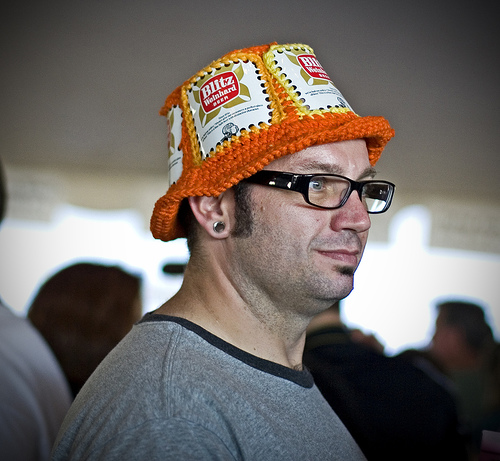

In [6]:
# printing some images with their captions

# function to get the size of images
def image_size(image_file):
    with PILImage.open(image_file) as img:
        return img.size

from IPython.display import Image, display
for i in range(5):
    # image file name
    image_name = os.path.join(images_path, images_name_list[i])
    # respective captions
    captions = list(captions_df[captions_df['image'] == images_name_list[i]]['caption'].values)
    print(images_name_list[i], ', size:', image_size(image_name))
    for caption in captions:
        print(caption)
    display(Image(filename=image_name))
    print()

## Getting image features 

In [7]:
# getting vgg16 model and removing the last softmax layer

cnn = VGG16()
cnn = Model(inputs=cnn.inputs, outputs=cnn.layers[-2].output)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# saving features in a dict against their image id

def image_features(images_path, images_list, model, size=(224, 224)):
    image_features = {}
    for i in tqdm(range(len(images_list))):
        path = os.path.join(images_path, images_list[i])
        image = load_img(path, target_size=size)
        img_arr = img_to_array(image)
        img_arr = np.expand_dims(img_arr, axis=0)
        img_arr = preprocess_input(img_arr)
        features = model.predict(img_arr, verbose=0)
        image_features[images_list[i]] = features
    return image_features


In [9]:
image_features_dict = image_features(images_path, images_name_list, cnn)

  0%|          | 0/8091 [00:00<?, ?it/s]

In [10]:
# saving the features

pickle.dump(image_features_dict, open(os.path.join('', 'image_features.pkl'),'wb'))

In [ ]:
# loading them

with open(os.path.join('', 'image_features.pkl'), 'rb') as f:
    image_features_dict = pickle.load(f)

## Extracting Image captions and preprocessing them

In [11]:
# creating a dict to keep all the captions corresponding to an image

def caption_mapping(df):
    image_captions = {}
    for i in tqdm(range(len(df))):
        image = df.iloc[i,0]
        caption = df.iloc[i,1]
        if image in image_captions:
            image_captions[image].append(caption)
        else:
            image_captions[image] = []
            image_captions[image].append(caption)
    return image_captions

In [12]:
image_captions_dict = caption_mapping(captions_df)
len(image_captions_dict)

  0%|          | 0/40455 [00:00<?, ?it/s]

8091

In [13]:
# cleaning the captions: lowercase, removing special characters, extra space

def preprocessing_text(captions_dict):
    for image_id, captions in captions_dict.items():
        for i in range(len(captions)):
            caption = captions[i]
            # lowercasing the words
            caption = caption.lower()
            # Remove special characters and numbers
            caption = re.sub(r'[^a-zA-Z\s]', '', caption)
            # adding <start> and <end> to each caption
            caption = '<start> ' + caption + ' <end>'
            captions[i] = caption

preprocessing_text(image_captions_dict)

In [14]:
# getting all captions to tokenize them
all_captions = []
for i in image_captions_dict:
    for caption in image_captions_dict[i]:
        all_captions.append(caption)
print(len(all_captions))

# tokenizing the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
# adding 1 to the vocab size: to reserve one index for padding later
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

# getting max length of captions for padding later
max_length = max(len(caption.split()) for caption in all_captions)

40455
8779


## Train Test split

In [15]:
image_ids = list(image_captions_dict.keys())
# performing a 85 - 15 train test split
split = int(len(image_ids) * 0.85)
train = image_ids[:split]
test = image_ids[split:]

In [16]:
# create data generator to get data in batch (avoids session crash, optimize memory usage)

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

## Encoder-Decoder Model

In [19]:
# -----ENCODER MODEL-----

# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


# -----DECODER MODEL-----

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot_model(model, show_shapes=True)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 37)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 37, 256)              2247424   ['input_7[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 4096)                 0         ['input_6[0][0]']             
                                                                                            